In [1]:
from src.setup.mlflow_setup import init_mlflow

MLflow initialization module imported.


In [21]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from mlflow.models.signature import infer_signature

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [22]:
init_mlflow()

In [23]:
df = pd.read_csv('../data/raw/telecom.csv')

In [ ]:
# df['ratio_day_night_calls'] = round(df['total_day_calls'] / df['total_night_calls'], 2)
# df['ratio_day_night_calls'] = df['ratio_day_night_calls'].replace([np.inf, -np.inf], 0)

In [ ]:
# df['ratio_day_night_calls'].value_counts()

ratio_day_night_calls
0.92    74
0.89    72
0.94    71
1.05    68
0.97    67
        ..
0.36     1
2.14     1
2.29     1
2.48     1
2.53     1
Name: count, Length: 206, dtype: int64

In [24]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [25]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

In [26]:
X = df.drop(['churn'], axis=1)

In [27]:
y = df['churn']

In [28]:
y = y.map({'no': 0, 'yes': 1})

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [30]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [31]:
numeric = df.select_dtypes(include='number').columns

In [32]:
categorical = df.select_dtypes(exclude='number').columns

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric),
        ('cat', categorical_transformer, categorical.drop('churn'))
    ])

pipeline_weighted = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])
                        # ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear'))])

pipeline_weighted.fit(X_train, y_train)


y_pred = pipeline_weighted.predict(X_test)

cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1205
           1       0.58      0.25      0.35       198

    accuracy                           0.87      1403
   macro avg       0.74      0.61      0.64      1403
weighted avg       0.84      0.87      0.85      1403



In [34]:
from src.ml_models.model import TelecomLogisticRegression

In [24]:
Xt = preprocessor.fit_transform(X_train)
print(type(Xt))
print(Xt.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(2848, 70)


In [35]:
categorical_cols = categorical.drop('churn').tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric.to_list()),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline_weighted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', TelecomLogisticRegression(class_weight='balanced'))
])

pipeline_weighted.fit(X_train, y_train)
y_pred = pipeline_weighted.predict(X_test)


cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1205
           1       0.30      0.73      0.42       198

    accuracy                           0.72      1403
   macro avg       0.62      0.72      0.62      1403
weighted avg       0.85      0.72      0.76      1403



c:\Users\Никита\Desktop\ML_CV\telecom_project\predictify_train\venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [36]:
mlflow.set_experiment("churn_classification")      # имя эксперимента

with mlflow.start_run():

    # --- 1. Логируем параметры модели ---
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("class_weight", "balanced")

    # --- 2. Делаем предсказание ---
    y_pred = pipeline_weighted.predict(X_test)

    # --- 3. Метрики ---
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    # можно логировать текстовый classification_report как артефакт
    # report = classification_report(y_test, y_pred)
    # with open("cls_report.txt", "w") as f:
    #     f.write(report)
    # mlflow.log_artifact("cls_report.txt")

    # --- 4. Логируем сам PIPELINE ---
    mlflow.sklearn.log_model(
        sk_model=pipeline_weighted,
        name="model",
        registered_model_name="ChurnPipeline",  # опционально
        code_paths=["../src"]
    )

    print("Model logged to MLflow!")

c:\Users\Никита\Desktop\ML_CV\telecom_project\predictify_train\venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
2025/11/24 22:50:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'ChurnPipeline' already exists. Creating a new version of this model...
2025/11/24 22:50:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ChurnPipeline, version 5
Created version '5' of model 'ChurnPipeline'.


Model logged to MLflow!
🏃 View run trusting-finch-303 at: http://94.228.117.198:5000/#/experiments/2/runs/7f015dccbfc94e788ac63cb05ad899e6
🧪 View experiment at: http://94.228.117.198:5000/#/experiments/2


c:\Users\Никита\Desktop\ML_CV\telecom_project\predictify_train\venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


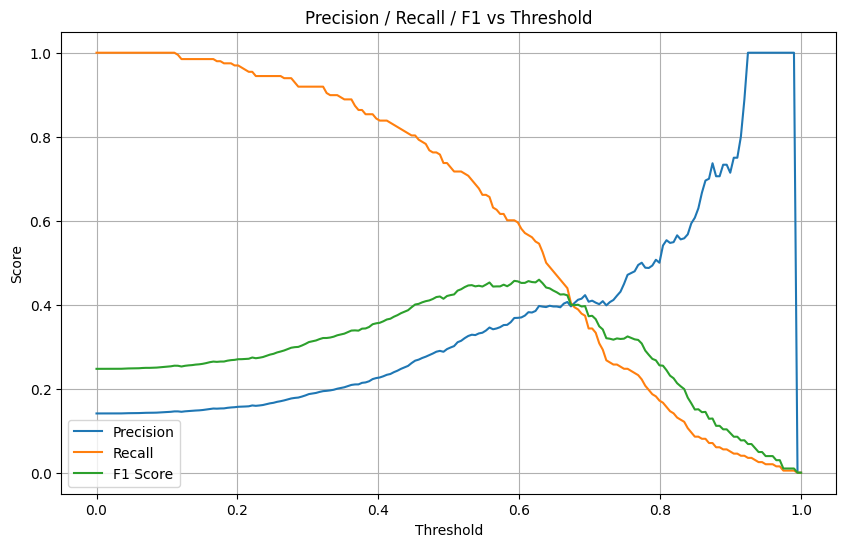

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Предсказываем вероятности
y_proba = pipeline_weighted.predict_proba(X_test)[:, 1]

# 2) Определяем пороги — от 0 до 1
thresholds = np.linspace(0, 1, 200)

precisions = []
recalls = []
f1s = []

# 3) Считаем метрики для каждого порога
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))
    f1s.append(f1_score(y_test, y_pred, zero_division=0))

# 4) Строим график
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
